# Data Overview

In [1]:
import pandas as pd
import pandas as pd
from main import get_data, export_data
import os
from get_average_sentiment import load_mean_count
(root, data_path, presidents, cities, countries, years, colors) = get_data()

In [2]:
mean_compound = pd.read_pickle('results/mean_compound.pkl')

In [3]:
mean_compound

,Birmingham,LA,London,NYC,Great Britain,US,Total
trump,0.000941,-0.061045,0.026475,-0.049612,0.022986,-0.05551,-0.046108
johnson,0.054013,0.184652,0.026248,0.164726,0.031557,0.174949,0.061519
All,0.239253,0.156903,0.228856,0.143292,0.230849,0.150487,0.176390


In [4]:
total_count_path = f'results/total_count.pkl'
if os.path.exists(total_count_path):
    total_count = pd.read_pickle(total_count_path)
else:
    total_count = pd.DataFrame(index=[presidents[0], presidents[1], 'President Total', 'All'], columns=(cities + countries + ['Total']))
    for city in cities:
        total_count.at['All', city] = int(load_mean_count(f'{city}_mean_count', 'total_count'))

        city_trump = pd.read_pickle(f'{data_path}/trump-{city}.pkl')
        city_johnson = pd.read_pickle(f'{data_path}/johnson-{city}.pkl')
        total_count.at[presidents[0], city] = city_trump.shape[0]
        total_count.at[presidents[1], city] = city_johnson.shape[0]

    for row in total_count.index:
        total_count.at[row, countries[0]] = total_count.at[row, 'Birmingham'] + total_count.at[row, 'London']
        total_count.at[row, countries[1]] = total_count.at[row, 'LA'] + total_count.at[row, 'NYC']

    trump = pd.read_pickle(f'{data_path}/trump.pkl')
    johnson = pd.read_pickle(f'{data_path}/johnson.pkl')
    total_count.at[presidents[0], 'Total'] = trump.shape[0]
    total_count.at[presidents[1], 'Total'] = johnson.shape[0]

    for col in total_count.columns:
        total_count.at['President Total', col] = total_count.at[presidents[0], col] + total_count.at[presidents[1], col]

    total_count.at['All', 'Total'] = total_count.at['All', countries[0]] + total_count.at['All', countries[1]]
    export_data(total_count, f'results/total_count')
total_count

,Birmingham,LA,London,NYC,Great Britain,US,Total
trump,26758,742399,169071,696803,195829,1439202,1635031
johnson,50952,45289,223714,41560,274666,86849,361515
President Total,77710,787688,392785,738363,470495,1526051,1996546
All,7148908,41449103,30145037,36959351,37293945,78408454,115702399


In [5]:
# Increase text size for visibility in seminar thesis
text_fontsize = 18
title_fontsize = 24
label_fontsize = 16
legend_fontsize = text_fontsize

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_mean_compound(data, title=None, filename=None, colors=colors, bar_width=0.35):
    # Font size specifications
    text_fontsize = 18
    title_fontsize = 24
    label_fontsize = 16
    legend_fontsize = text_fontsize

    # Ensure colors is a list with enough colors
    if colors is None or len(colors) < len(data.index):
        # Default to a grayscale if colors are not provided or insufficient
        colors = [f"#{i}{i}{i}" for i in range(len(data.index), 0, -1)]

    # Calculate the number of groups and the total number of bars in each group
    n_groups = data.shape[1]
    n_bars = data.shape[0]

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(10, 5))

    # Set up the seaborn style for nicer plots
    sns.set(style="whitegrid")

    # Calculate the width of the entire group of bars
    group_width = bar_width * n_bars

    # Set the positions of the bars
    index = np.arange(n_groups) * (group_width + bar_width)  # Space out the groups
    bar_positions = [index + (bar_width * i) for i in range(n_bars)]

    # Plot bars for each president
    for i, president in enumerate(data.index):
        ax.bar(bar_positions[i], data.loc[president], bar_width, label=president.capitalize(), color=colors[i])

    # Set the position of the x ticks and labels to be in the middle of the group
    ax.set_xticks(index + group_width / 2 - bar_width / 2)
    ax.set_xticklabels(data.columns, fontsize=legend_fontsize)
    # Set the labels and title with specified font sizes
    ax.set_xlabel('Location', fontsize=label_fontsize)
    ax.set_ylabel('Mean Compound Sentiment Score', fontsize=label_fontsize)
    ax.set_title(title if title else "Mean Compound Sentiment by Location", fontsize=title_fontsize)
    ax.legend(fontsize=legend_fontsize)

    # Show the plot
    plt.tight_layout()
    if filename:
        plt.savefig(f'visualizations/compound_sentiment/{filename}.png', format='png', bbox_inches='tight')
    plt.show()


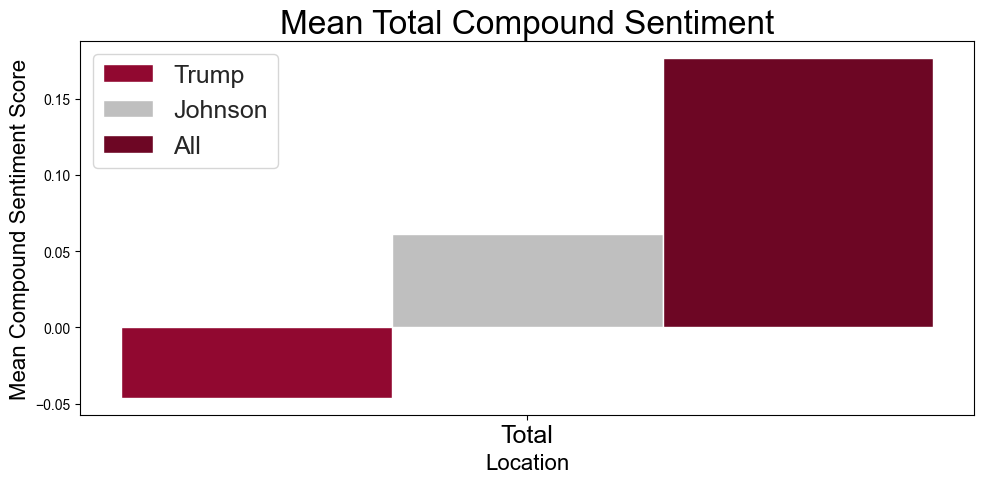

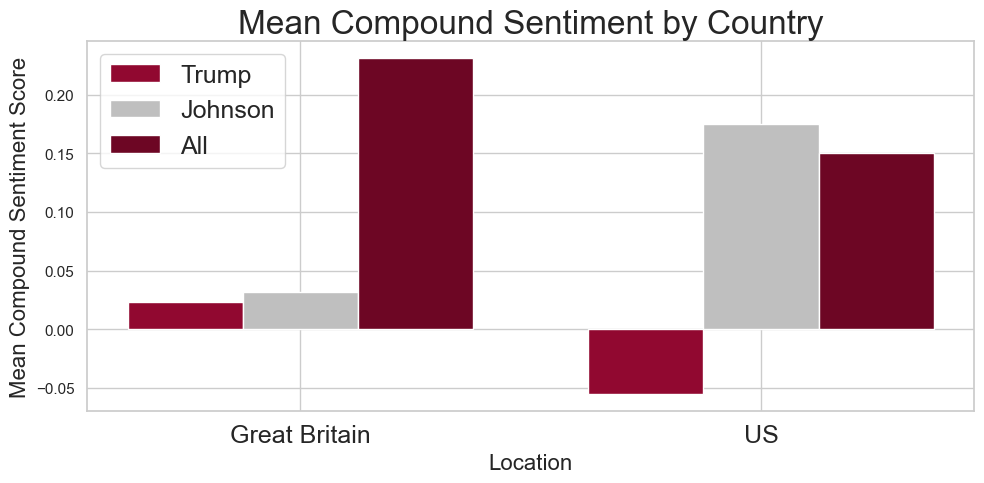

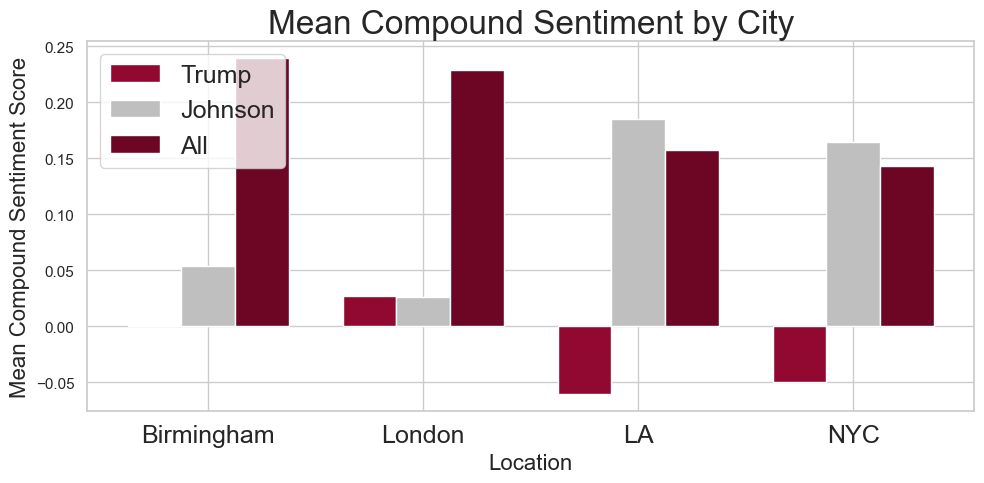

In [7]:
plot_mean_compound(
    mean_compound[mean_compound.columns[-1:]],
    title='Mean Total Compound Sentiment',
    filename='mean_compound_sentiment',
)
plot_mean_compound(
    mean_compound[mean_compound.columns[-3:-1]],
    title='Mean Compound Sentiment by Country',
    filename='mean_compound_sentiment_by_country',
)
plot_mean_compound(
    mean_compound[[cities[i] for i in [0, 2, 1, 3]]],
    title='Mean Compound Sentiment by City',
    filename='mean_compound_sentiment_by_city',
)

##### Emoji Handeling

In [12]:
d = pd.read_pickle(f'{data_path}johnson-LA.pkl')
d[d["text"].str.contains('BorisJohnson Survives')][['text','Compound']]

,text,Compound
46882,#BorisJohnson Survives 😡🤬,0.0


Emojis are apparently not completely recognized by the sentiment scoring/sentiment grading technique. It may be because of different emoji encoding.

##### Location-Based Mean Tweets Per Day

In [13]:
from get_mean_count import load_json_data
number_of_days = load_json_data('results/number_of_days.json')

In [15]:
def get_mean_tweets_per_day():
    # get an overview of mean tweets per day in each location
    # get total tweet count to get the mean tweets per day independent from the presidents
    total_count = pd.read_pickle('results/total_count.pkl')
    total_count = total_count.rename(columns={"Total": "All"})
    
    # get president-related mean tweets per day
    locations = countries + cities
    tweets_per_day = pd.DataFrame(columns=locations)
    
    for col in locations:
        tweets_per_day.at['All', col] = total_count.at['All', col] / number_of_days
    
    population_key = 'Population'
    # population in million - based on Google search on 03.02.2024
    tweets_per_day.at[population_key, 'NYC'] = 8468
    tweets_per_day.at[population_key, 'LA'] = 3849
    tweets_per_day.at[population_key, 'Birmingham'] = 1149
    tweets_per_day.at[population_key, 'London'] = 8982
    tweets_per_day.at[population_key, 'Great Britain'] = tweets_per_day.at[population_key, 'Birmingham'] + tweets_per_day.at[population_key, 'London']
    tweets_per_day.at[population_key, 'US'] = tweets_per_day.at[population_key, 'LA'] + tweets_per_day.at[population_key, 'NYC']

    tweets_per_day.loc['Posts per Inhabitant'] = tweets_per_day.loc['All'] / tweets_per_day.loc[population_key]

    # tweets_per_day.to_pickle(f'{data_path}tweets_per_day.pkl')
    return tweets_per_day

get_mean_tweets_per_day()

TypeError: unsupported operand type(s) for /: 'int' and 'dict'